In [ ]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Select

The `SELECT` operation, defined by $$ SELECT \left( | i \rangle \otimes | \psi \rangle \right) = |i \rangle \otimes U_i | \psi \rangle $$ is a fundamental primitive in quantum computing. In recent years techniques such as Quantum Singular Value Transformations (QSVT) have brought about a unifying way to construct virtually all known quantum algorithms. Qualtran has a few different techniques for implementing these oracles; this article aims to explain how the basic construction known as Unary Iteration is implemented. Towards the end variants such as SELECT-SWAP or QROAM, as well as pointers to specific implementations for physical systems such as chemical systems or Hubbard Models are mentioned. 

## Unary Iteration

Throughout the following discussion we will use the universal gate set of Clifford + T gates. We also assume that the user has a control register `ctrl` that contains the state to be "selected on" and a system register `sys` that the target unitaries are applied to. We first will go through a very simple SELECT Circuit in which one has a `ctrl` register of 3 qubits, a system register of 1 qubit, and the target unitaries to be applied are $U_0, U_1, \ldots, U_7$. In symbols, $SELECT = \sum_{i = 0}^7 |i\rangle\langle i | \otimes U_i$. A typical assumption made when constructing a SELECT circuit is that we have access to a single qubit controlled version of the unitaries, i.e. $|1 \rangle \langle 1| \otimes U_i$, where the $|1\rangle \langle 1|$ acts on one ancilla qubit that is not in the `ctrl` register. 

This constraint makes our job now fairly clear: we have to come up with a way of flipping an ancilla qubit, say from a register of ancilla qubits `a[n]`, if the `ctrl` register is in the state $|i\rangle$ and applying the controlled $U_i$'s based on `a[n]`. We will be able to do this with just Toffolis and bit flips. First we will walk through the circuit that applies the first three controlled unitaries, as that is enough to get the big picture. 

To apply the first unitary we need to have an ancilla flipped to 1 if the `ctrl` qubits are all 0. This is done with Toffoli's and bit flips to implement AND

In [44]:
from qualtran import BloqBuilder, QUInt, QAny, QBit
from qualtran.bloqs.basic_gates.rotation import CZPowGate
from qualtran.bloqs.basic_gates.toffoli import Toffoli
from qualtran.bloqs.basic_gates.x_basis import XGate
from qualtran.drawing.musical_score import draw_musical_score, get_musical_score_data
from qualtran.drawing import get_musical_score_data, draw_musical_score

bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(3))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QAny(2))
ancs = bb.split(anc)
system = bb.add_register_from_dtype("system", QBit())

for ix in range(len(ctrls)):
    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])

[ctrls[0], ctrls[1]], ancs[0] = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=ancs[0])
[ancs[0], ctrls[2]], ancs[1] = bb.add(Toffoli(), ctrl=[ancs[0], ctrls[2]], target=ancs[1])
[ancs[1], system] = bb.add(CZPowGate(exponent=0.0), q=[ancs[1], system])


Now if we want to view the SELECT circuit so far we can run `join` all of our qubits together and draw the musical score diagram

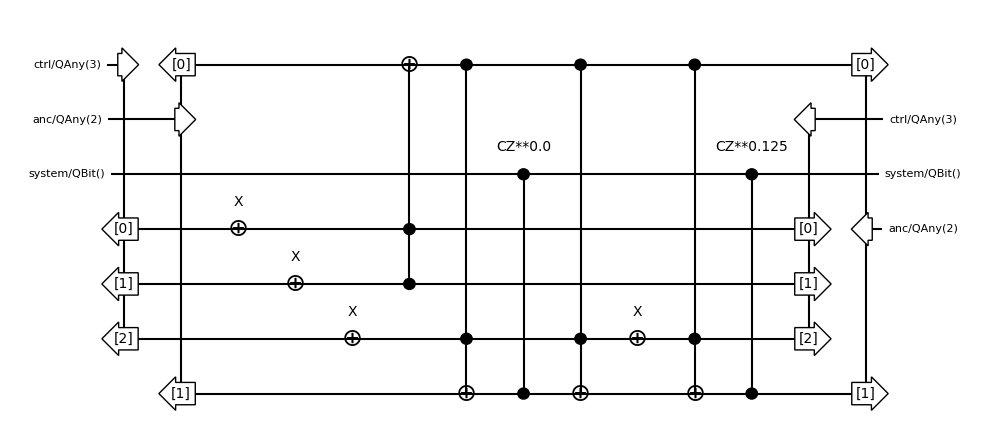

In [46]:
ctrl = bb.join(ctrls)
anc = bb.join(ancs)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, system=system)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

The above bloq diagram shows the first controlled rotation applied to our system conditioned on all three control registers being in the 0 state. If we wanted to proceed with our additionally controlled rotations, we could do so naively by uncomputing the ancillas and undoing the $X$ operations on `ctrl`. After this reset, we could flip the two leading `ctrl` qubits and repeat the procedure to apply a controlled rotation if `ctrl` is in `001` or 1. The key insight of unary iteration is that this resetting leads to a lot of wasted computation, and by using these intermediately computed values we can save a lot of T gates. 

The next controlled operation we need to do for SELECT is $|001\rangle\langle001| \otimes U_1$. By not uncomputing our work, the ancillas currently have information we can take advantage of. The first ancilla `ancs[0]` is 1 if the first two qubits of `ctrl` are 0 and is 0 otherwise. This information is useful if we want to SELECT on `000` (what we just did) or `001` (what we want to do now). Since `ancs[1]` stores `ancs[0] & ~ctrl[2]` we can simply flip 

Now all we have to do is uncompute the last ancilla bit and compute our new information. We use this bit of information and only uncompute the last bit stored in `ancs[1]`, which is 1 if (`~ctrls[0]` & `~ctrls[1]`) & `~ctrls[2]`. Uncomputing the last Toffoli between `ctrls[2]` and `ancs[0]` leaves `ancs[1]` in the $|0\rangle$ state. Now we put the logical value `ancs[0] & ctrls[2]` in `ancs[1]`, which works to be `~ctrls[0] & ~ctrls[1] & ctrls[2]`, or `1` if `ctrls = 001` and `0` otherwise. This is done in qualtran in the following code block.

In [45]:
[ctrls[2], ancs[0]], ancs[1] = bb.add(Toffoli(), ctrl=[ctrls[2], ancs[0]], target=ancs[1])
ctrls[2] = bb.add(XGate(), q=ctrls[2])
[ctrls[2], ancs[0]], ancs[1] = bb.add(Toffoli(), ctrl=[ctrls[2], ancs[0]], target=ancs[1])
[ancs[1], system] = bb.add(CZPowGate(exponent=1./ 8.),q=[ancs[1], system])

Now viewing the circuit diagram we see that we saved ourselves 2 Toffolis, the 1 that would have been used to uncompute `ancs[0]` and then recompute it. To move forward with the SELECT circuit, we would need to query `010`, which would require uncomputing `ancs[0]`, flipping `ctrls[1]`, and then storing `~ctrls[0] & ctrls[1]` into `ancs[0]`. Then we would be able to query `010` and `011` with this value of `ancs[0]` before uncomputing it and moving to `100` and so on. We see that by reusing information we save 2 Toffoli gates 

Given an array of potential operations, for example:

    ops = [X(i) for i in range(5)]
    
we would like to select an operation to apply:

    n = 4 --> apply ops[4]
    
If $n$ is a quantum integer, we need to apply the transformation

$$
    |n \rangle |\psi\rangle \rightarrow |n\rangle \, \mathrm{ops}_n \cdot |\psi\rangle
$$

The simplest conceptual way to do this is to use a "total control" quantum circuit where you introduce a multi-controlled operation for each of the `len(ops)` possible `n` values.

In [ ]:
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np
from typing import *

In [ ]:
import operator
import cirq._compat
import itertools

## Total Control

Here, we'll use Sympy's boolean logic to show how total control works. We perform an `And( ... )` for each possible bit pattern. We use an `Xnor` on each selection bit to toggle whether it's a positive or negative control (filled or open circle in quantum circuit diagrams).

In this example, we indeed consider $X_n$ as our potential operations and toggle bits in the `target` register according to the total control.

In [ ]:
import sympy as S
import sympy.logic.boolalg as slb

def total_control(selection, target):
    """Toggle bits in `target` depending on `selection`."""
    print(f"Selection is {selection}")
    
    for n, trial in enumerate(itertools.product((0, 1), repeat=len(selection))):
        print(f"Step {n}, apply total control: {trial}")
        target[n] ^= slb.And(*[slb.Xnor(s, t) for s, t in zip(selection, trial)])
          
        if target[n] == S.true:
            print(f"  -> At this stage, {n}= and our output bit is set")

        
selection = [0, 0, 0]
target = [False]*8
total_control(selection, target)    
print()
print("Target:")
print(target)

Note that our target register shows we have indeed applied $X_\mathrm{0b010}$. Try changing `selection` to other bit patterns and notice how it changes.

Of course, we don't know what state the selection register will be in. We can use sympy's support for symbolic boolean logic to verify our gadget for all possible selection inputs.

In [ ]:
selection = [S.Symbol(f's{i}') for i in range(3)]
target = [S.false for i in range(2**len(selection)) ]
total_control(selection, target)

print()
print("Target:")
for n, t in enumerate(target):
    print(f'{n}= {t}')
    
tc_target = target.copy()

As expected, the "not pattern" (where `~` is boolean not) matches the binary representations of `n`.

## Unary Iteration with segment trees

A [segment tree](https://en.wikipedia.org/wiki/Segment_tree) is a data structure that allows logrithmic-time querying of intervals. We use a segment tree where each interval is length 1 and comprises all the `n` integers we may select.

It is defined recursively by dividing the input interval into two half-size intervals until the left limit meets the right limit.

In [ ]:
def segtree(ctrl, selection, target, depth, left, right):
    """Toggle bits in `target` depending on `selection` using a recursive segment tree."""
    print(f'depth={depth} left={left} right={right}', end=' ')
    
    if left == (right - 1):
        # Leaf of the recusion.
        print(f'n={n} ctrl={ctrl}')
        target[left] ^= ctrl
        return 
    print()
    
    assert depth < len(selection)
    mid = (left + right) >> 1
    
    # Recurse left interval
    new_ctrl = slb.And(ctrl, slb.Not(selection[depth]))
    segtree(ctrl=new_ctrl, selection=selection, target=target, depth=depth+1, left=left, right=mid)
    
    # Recurse right interval
    new_ctrl = slb.And(ctrl, selection[depth])
    segtree(ctrl=new_ctrl, selection=selection, target=target, depth=depth+1, left=mid, right=right)
    
    # Quantum note:
    # instead of throwing away the first value of `new_ctrl` and re-anding
    # with selection, we can just invert the first one (but only if `ctrl` is active)
    # new_ctrl ^= ctrl

In [ ]:
selection = [S.Symbol(f's{i}') for i in range(3)]
target = [S.false for i in range(2**len(selection)) ]
segtree(S.true, selection, target, 0, 0, 2**len(selection))

print()
print("Target:")
for n, t in enumerate(target):
    print(f'n={n} {slb.simplify_logic(t)}')

In [ ]:
print(f"{'n':3s} | {'segtree':18s} | {'total control':18s} | same?")
for n, (t1, t2) in enumerate(zip(target, tc_target)):
    t1 = slb.simplify_logic(t1)
    print(f'{n:3d} | {str(t1):18s} | {str(t2):18s} | {str(t1==t2)}')

## Quantum Circuit

We can translate the boolean logic to reversible, quantum logic. It is instructive to start from the suboptimal total control quantum circuit for comparison purposes. We can build this as in the sympy boolean-logic case by adding controlled X operations to the target signature, with the controls on the selection signature toggled on or off according to the binary representation of the selection index.

Let us first build a GateWithRegisters object to implement the circuit

In [ ]:
import cirq
from functools import cached_property
from qualtran import Signature, GateWithRegisters, QUInt

class TotallyControlledNot(GateWithRegisters):
    
    def __init__(self, selection_bitsize: int, target_bitsize: int, control_bitsize: int = 1):
        self._selection_bitsize = selection_bitsize
        self._target_bitsize = target_bitsize
        self._control_bitsize = control_bitsize

    @cached_property
    def signature(self) -> Signature:
        return Signature(
            [
                *Signature.build(control=self._control_bitsize),
                *Signature.build(selection=self._selection_bitsize),
                *Signature.build(target=self._target_bitsize)
            ]
        )

    def decompose_from_registers(self, **qubit_regs: Sequence[cirq.Qid]) -> cirq.OP_TREE:
        num_controls = self._control_bitsize + self._selection_bitsize
        for target_bit in range(self._target_bitsize):
            bit_pattern = QUInt(self._selection_bitsize).to_bits(target_bit)
            control_values = [1]*self._control_bitsize + list(bit_pattern)
            yield cirq.X.controlled(
                num_controls=num_controls,
                control_values=control_values
                ).on(
                    *qubit_regs["control"], 
                    *qubit_regs["selection"],
                    qubit_regs["target"][-(target_bit+1)])
        

In [ ]:
import qualtran.cirq_interop.testing as cq_testing
tc_not = TotallyControlledNot(3, 5)
tc = cq_testing.GateHelper(tc_not)
cirq.Circuit((cirq.decompose_once(tc.operation)))
SVGCircuit(cirq.Circuit(cirq.decompose_once(tc.operation)))

## Tests for Correctness

We can use a full statevector simulation to compare the desired statevector to the one generated by the unary iteration circuit for each basis state.

In [ ]:
selection_bitsize = 3
target_bitsize = 5
for n in range(target_bitsize):
    # Initial qubit values
    qubit_vals = {q: 0 for q in tc.all_qubits}
    # All controls 'on' to activate circuit
    qubit_vals.update({c: 1 for c in tc.quregs['control']})
    # Set selection according to `n`
    qubit_vals.update(zip(tc.quregs['selection'], QUInt(selection_bitsize).to_bits(n)))

    initial_state = [qubit_vals[x] for x in tc.all_qubits]
    final_state = [qubit_vals[x] for x in tc.all_qubits]
    final_state[-(n+1)] = 1
    cq_testing.assert_circuit_inp_out_cirqsim(
        tc.circuit, tc.all_qubits, initial_state, final_state
    )
    print(f'n={n} checked!')

## Towards a segment tree 

Next let's see how we can reduce the circuit to the observe the tree structure.
First let's recall what we are trying to do with the controlled not. Given a
selection integer (say 3 = 011), we want to toggle the bit in the target
register to on if the qubit 1 and 2 are set to on in the selection register.

In [ ]:
# The selection bits [1-3] are set according to binary representation of the number 3 (011)
initial_state = [1, 0, 1, 1, 0, 0, 0, 0, 0]
final_state = [1, 0, 1, 1, 0, 1, 0, 0, 0]
actual, should_be = cq_testing.get_circuit_inp_out_cirqsim(
        tc.circuit, tc.all_qubits, initial_state, final_state
    )
print("simulated: ", actual)
print("expected : ", should_be)


Now what is important to note is that we can remove many repeated controlled operations by using ancilla qubits to flag what part of the circuit we need to apply, this works because we know the bit pattern of nearby integers is very similar. 

A circuit demonstrating this for our example is given below.

In [ ]:
from qualtran.bloqs.mcmt import And

selection_bitsize = 2
target_bitsize = 4
qubits = cirq.LineQubit(0).range(1 + selection_bitsize * 2 + target_bitsize)
circuit = cirq.Circuit()
circuit.append(
    [
        And(1, 0).on(qubits[0], qubits[1], qubits[2]),
        And(1, 0).on(qubits[2], qubits[3], qubits[4]),
        cirq.CX(qubits[4], qubits[8]),
        cirq.CNOT(qubits[2], qubits[4]),
        cirq.CX(qubits[4], qubits[7]),
        And().adjoint().on(qubits[2], qubits[3], qubits[4]),
        cirq.CNOT(qubits[0], qubits[2]),
        And(1, 0).on(qubits[2], qubits[3], qubits[4]),
        cirq.CX(qubits[4], qubits[6]),
        cirq.CNOT(qubits[2], qubits[4]),
        cirq.CX(qubits[4], qubits[5]),
        And().adjoint().on(qubits[2], qubits[3], qubits[4]),
        And().adjoint().on(qubits[0], qubits[1], qubits[2]),
    ]
)

SVGCircuit(circuit)

Reading from left to right we first check the control is set to on and the selection qubit is off, if both these conditions are met then the ancilla qubit is now set to 1. The next control checks if the previous condition was met and likewise the second selection index is also off. At this point if both these conditions are met we must be indexing 0 as the first two qubits are set to off (00), otherwise we know that we want to apply X to qubit 1 so we perform a CNOT operation to flip the bit value in the second ancilla qubit, before returning back up the circuit. Now if the left half of the circuit was not applied (i.e. the first selection register was set to 1) then the CNOT between the control qubit and the first ancilla qubit causes the ancilla qubit to toggle on. This triggers the right side of the circuit, which now performs the previously described operations to figure out if the lowest bit is set. Combining these two then yields the expected controlled X operation. 

Below we check the circuit is giving the expected behaviour.

In [ ]:
initial_state = [1, 0, 0, 0, 0, 0, 0, 0, 0]
target_indx = 3
sel_bits = QUInt(selection_bitsize).to_bits(target_indx)
sel_indices = [i for i in range(1, 2*selection_bitsize+1, 2)]
initial_state[sel_indices[0]] = sel_bits[0]
initial_state[sel_indices[1]] = sel_bits[1]
result = cirq.Simulator(dtype=np.complex128).simulate(
    circuit, initial_state=initial_state
)
actual = result.dirac_notation(decimals=2)[1:-1]
print("simulated: {}, index set in string {}".format(actual, len(qubits)-1-target_indx))

Extending the above idea to larger ranges of integers is relatively straightforward. For example consider the next simplest case of $L=8 = 2^3$. The circuit above takes care of the last two bits and can be duplicated. For the extra bit we just need to add a additional `AND` operations, and a CNOT to switch between the original range `[0,3]` or the new range `[4,7]` depending on whether the new selection register is off or on respectively. This procedure can be repeated and we can begin to notice the recursive tree-like structure. 

This structure is just the segtree described previously for boolean logic and this gives is the basic idea of unary iteration, 
which uses `L-1` `AND` operations. Below the `ApplyXToLthQubit` builds the controlled Not operation using the `UnaryIterationGate` as a base class which defines the `decompose_from_registers` method appropriately to recursively construct the unary iteration circuit.

Note below a different ordering of ancilla and selection qubits is taken to what was used in the simpler `L=4` example.

In [ ]:
from qualtran import QAny, Register, Register, BoundedQUInt
from qualtran.bloqs.multiplexers.unary_iteration_bloq import UnaryIterationGate
from functools import cached_property



class ApplyXToLthQubit(UnaryIterationGate):
    def __init__(self, selection_bitsize: int, target_bitsize: int, control_bitsize: int = 1):
        self._selection_bitsize = selection_bitsize
        self._target_bitsize = target_bitsize
        self._control_bitsize = control_bitsize

    @cached_property
    def control_registers(self) -> Tuple[Register, ...]:
        return (Register('control', QAny(self._control_bitsize)),)

    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        return (Register('selection', BoundedQUInt(self._selection_bitsize, self._target_bitsize)),)

    @cached_property
    def target_registers(self) -> Tuple[Register, ...]:
        return (Register('target', QAny(self._target_bitsize)),)

    def nth_operation(
        self, context, control: cirq.Qid, selection: int, target: Sequence[cirq.Qid]
    ) -> cirq.OP_TREE:
        return cirq.CNOT(control, target[-(selection + 1)])

In [ ]:
import qualtran.cirq_interop.testing as cq_testing
selection_bitsize = 3
target_bitsize = 5

g = cq_testing.GateHelper(
    ApplyXToLthQubit(selection_bitsize, target_bitsize))
SVGCircuit(cirq.Circuit(cirq.decompose_once(g.operation)))

## Tests for Correctness

We can use a full statevector simulation to check again that the optimized circuit produces the expected result.

In [ ]:
from qualtran import QUInt

for n in range(target_bitsize):
    # Initial qubit values
    qubit_vals = {q: 0 for q in g.all_qubits}
    # All controls 'on' to activate circuit
    qubit_vals.update({c: 1 for c in g.quregs['control']})
    # Set selection according to `n`
    qubit_vals.update(zip(g.quregs['selection'], QUInt(selection_bitsize).to_bits(n)))

    initial_state = [qubit_vals[x] for x in g.all_qubits]
    qubit_vals[g.quregs['target'][-(n + 1)]] = 1
    final_state = [qubit_vals[x] for x in g.all_qubits]
    cq_testing.assert_circuit_inp_out_cirqsim(
        g.decomposed_circuit, g.all_qubits, initial_state, final_state
    )
    print(f'n={n} checked!')